# Partial re-implementation of [Prior-aware autoencoders for lung pathology segmentation](https://www.sciencedirect.com/science/article/pii/S1361841522001384)

This paper is made up by 3 models:

1. a Partial Convolutionl Neural Network (PCNN) written as an autoencoder
2. a Normal Appearance Autoencoder model (NAA)
3. the Prior UNet which predicts the lung pathology segmentation mask.

This notebook will implement 2 and 3 the same way as the paper, but will the [Semantic Diffusion Model](https://github.com/WeilunWang/semantic-diffusion-model) instead for 1.

In [8]:
# !pip install torch numpy Pillow torchsummary torchvision matplotlib

In [9]:
import torch
from glob import glob
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import numpy as np
import os
from PIL import Image
import tqdm
import torch.nn.functional as F
!pip install opencv-python torchsummary
import cv2

## Module 1: Semantic Diffusion Model

The diffusion model has been trained and should be able to perform inference using the /scripts/luna16.sh script in the SDM folder.
Here, we only prepare the dataset that can be used to train the NAA model.

In [10]:
# # Directly inference from the trained SDM model to generate pathlogy free images
# # by running the /scripts/luna16.sh under the Semantic Diffusion Model directory

# # Prepare training and test dataset
# LESION_PATH = "/home/user/data/prior_train/gt/"
# # LESION_FREE_PATH = "/home/user/data/prior_train/lesion-free"
# LESION_FREE_PATH = "/home/user/data/prior_train/inpainted/"
# WEIGHT_MAP_PATH = "/home/user/luna-16-seg-diff-data/nodule_labels_ohe/"

# class NAAImageDataset(Dataset):
#   def __init__(self, lesion_path, lesion_free_path, weight_map_path):
#     self.lesion_path = lesion_path
#     self.lesion_free_path = lesion_free_path
#     self.weight_map_path = weight_map_path
#     self.file_list = os.listdir(self.lesion_path)
  
#   def __len__(self):
#     return len(self.file_list)
  
#   def __getitem__(self, idx):
#     filename = self.file_list[idx]
#     lesion_image = Image.open(os.path.join(self.lesion_path, filename))
#     lesion_free_image = Image.open(os.path.join(self.lesion_free_path, filename))
    
#     lesion_image = lesion_image.convert('L')
#     lesion_free_image = lesion_free_image.convert('L')
    
#     weight_map = Image.open(os.path.join(self.weight_map_path, filename[:-4]))
#     weight_map = weight_map.resize((256, 256))
#     weight_map = weight_map.convert('L')
#     # Convert the grayscale image to a NumPy array
#     grayscale_array = np.array(weight_map)
#     mask = grayscale_array > 0
#     converted_array = np.where(mask, 2, 0)
    
#     # Create a new image from the converted array
#     # converted_image = Image.fromarray(converted_array.astype(np.uint8))
    
#     return transforms.ToTensor()(lesion_image), transforms.ToTensor()(lesion_free_image), transforms.ToTensor()(converted_array)


# Directly inference from the trained SDM model to generate pathlogy free images
# by running the /scripts/luna16.sh under the Semantic Diffusion Model directory

# Prepare training and test dataset
LESION_PATH = '/home/user/data/prior_train/gt'
LESION_FREE_PATH = '/home/user/data/prior_train/inpainted'


class NAAImageDataset(Dataset):
    def __init__(self, lesion_path, lesion_free_path):
        self.lesion_images = sorted(glob(os.path.join(lesion_path, '*.png')))
        self.lesion_free_images = sorted(glob(os.path.join(lesion_free_path, '*.png')))
    
    def __len__(self):
          return len(self.lesion_images)
    
    def __getitem__(self, idx):
        lesion_image = cv2.imread(self.lesion_images[idx], 0)[..., None]
        lesion_free_image = cv2.imread(self.lesion_free_images[idx], 0)[..., None]
        
        q05 = np.quantile(lesion_image, 0.05)
        q95 = np.quantile(lesion_image, 0.95)
        lesion_image = np.clip(lesion_image, q05, q95).astype('float32')
        
        q05 = np.quantile(lesion_free_image, 0.05)
        q95 = np.quantile(lesion_free_image, 0.95)
        lesion_free_image = np.clip(lesion_free_image, q05, q95).astype('float32')
        
        return transforms.ToTensor()(lesion_image) / 255., transforms.ToTensor()(lesion_free_image) / 255.

In [11]:
dataset = NAAImageDataset(LESION_PATH, LESION_FREE_PATH)

# randomly split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# create dataloaders for train and test sets
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

## Module 2: Normal Appearance Autoencoder

For some reason NAA model would not work, so the code below is just for reference. The module 2 is instead implemented using the Diff-vae repo.

In [12]:
# Define the Normal Apperance Autoencoder (NAA). It consists of an input layer of size 512, 5 hidden layers of size 256, 128, 64, 64, 64 and a sampling layer for mean and logvar of size 64
# Define a convolution layer where each conv block consists of a conv2d layer, a batchnorm layer, then another conv2d layer followed by another batch normalization layer and finally a relu layer
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True, max_pool=True):
        super(ConvBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(2) if max_pool else None
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = self.layers(x)
        if self.maxpool is not None:
            x = self.maxpool(x)
        x = self.dropout(x)
        return x


class NAA(nn.Module):
    def __init__(self):
        super(NAA, self).__init__()
        self.encoder = torch.nn.Sequential(
            ConvBlock(1, 8, kernel_size=3),
            ConvBlock(8, 16, kernel_size=3),
            ConvBlock(16, 32, kernel_size=3, max_pool=False),
            ConvBlock(32, 64, kernel_size=3, max_pool=False),
            ConvBlock(64, 128, kernel_size=3, max_pool=False),
        )
        self.mean = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.logvar = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.mean_relu = nn.ReLU()
        self.logvar_relu = nn.ReLU()
        
        # few layers are commented out for experimental reasons
        self.decoder = torch.nn.Sequential(
            # nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # nn.Dropout(0.2),
            ConvBlock(64, 64, kernel_size=3, max_pool=False),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # nn.Dropout(0.2),
            ConvBlock(32, 32, kernel_size=3, max_pool=False),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.Dropout(0.2),
            ConvBlock(16, 16, kernel_size=3, max_pool=False),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.Dropout(0.2),
            ConvBlock(8, 8, kernel_size=3, max_pool=False),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Conv2d(1, 1, kernel_size=1),
            # nn.Sigmoid()
        )

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
        
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        x = self.encoder(x)
        mean = self.mean(x)
        logvar = self.logvar(x)
        z = self.reparameterize(self.mean_relu(mean), self.logvar_relu(logvar))
        x = self.decoder(z)
        return x, mean, logvar

In [13]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model = NAA().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
summary(model, input_size=(1, 256, 256))

# import gc
# model = model.cpu()
# del model
# gc.collect()
# torch.cuda.empty_cache()

Total number of parameters is: 859499
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]              80
       BatchNorm2d-2          [-1, 8, 256, 256]              16
            Conv2d-3          [-1, 8, 256, 256]             584
       BatchNorm2d-4          [-1, 8, 256, 256]              16
              ReLU-5          [-1, 8, 256, 256]               0
         MaxPool2d-6          [-1, 8, 128, 128]               0
           Dropout-7          [-1, 8, 128, 128]               0
         ConvBlock-8          [-1, 8, 128, 128]               0
            Conv2d-9         [-1, 16, 128, 128]           1,168
      BatchNorm2d-10         [-1, 16, 128, 128]              32
           Conv2d-11         [-1, 16, 128, 128]           2,320
      BatchNorm2d-12         [-1, 16, 128, 128]              32
             ReLU-13         [-1, 16, 128, 128]               0
 

In [14]:
from torch.optim.lr_scheduler import ExponentialLR

model = NAA().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.85)
num_epochs = 40

def loss_function(recon_x, input, target, mu, logvar, weight_map=None):  
  alpha = 0.001 # as suggested by the paper
  REC = F.mse_loss(recon_x, target, reduction='none')
  REC = REC.view(REC.size(0), -1).sum(1)
  REG = alpha * F.mse_loss(model.encode(input), model.encode(target), reduction='none')
  REG = REG.view(REG.size(0), -1).sum(1)
  KLD = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
  KLD = KLD.view(KLD.size(0), -1).sum(1)
  
  # print(REC.shape, REG.shape, KLD.shape)

  return (REC + REG + KLD).mean(), REC.mean(), REG.mean(), KLD.mean()

print("Training begins!")

for epoch in range(num_epochs):
  model.train()
  print(f"Epoch {epoch} begins:")
  with tqdm.tqdm(train_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free) in enumerate(tepoch):
      lesion = lesion.to(device)
      lesion_free = lesion_free.to(device)
      # weight_map = weight_map.to(device)
      optimizer.zero_grad()
      recon, mu, logvar = model(lesion)
      # print(model.parameters())
      # print(recon.shape)
      # print(mu.shape)
      # print(logvar.shape)
      loss, rec, reg, kld = loss_function(recon, lesion, lesion_free, mu, logvar)
      loss.backward()
      optimizer.step()
      
      if batch_idx % 20 == 0:
        tepoch.set_description(f"Epoch {epoch} / {num_epochs}, batch {batch_idx}, Loss: {loss / len(lesion)}, REC: {rec / len(lesion)}, REG: {reg / len(lesion)}, KLD: {kld / len(lesion)}")
        tepoch.set_postfix(loss=loss.item()/len(lesion))
    scheduler.step()

  model.eval()
  
  with torch.no_grad():
    with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
      for batch_idx, (lesion, lesion_free) in enumerate(tepoch):
        lesion = lesion.to(device)
        lesion_free = lesion_free.to(device)
        # weight_map = weight_map.to(device)
        recon, mu, logvar = model(lesion)
        loss, rec, reg, kld = loss_function(recon, lesion, lesion_free, mu, logvar)
        if batch_idx % 20 == 0:
          tepoch.set_description(f"Validation loss: {loss / len(lesion)}, REC: {rec / len(lesion)}, REG: {reg / len(lesion)}, KLD: {kld / len(lesion)}")


Training begins!
Epoch 0 begins:


Epoch 0 / 40, batch 40, Loss: 129554.46875, REC: 734.5148315429688, REG: 11.319766998291016, KLD: 128808.640625: 100%|██████████| 57/57 [00:06<00:00,  8.16batch/s, loss=1.3e+5] 
Validation loss: 180396.859375, REC: 506.26019287109375, REG: 0.01746286265552044, KLD: 179890.59375: 100%|██████████| 15/15 [00:01<00:00, 10.18batch/s]


Epoch 1 begins:


Epoch 1 / 40, batch 40, Loss: 98329.21875, REC: 279.04290771484375, REG: 11.985162734985352, KLD: 98038.1875: 100%|██████████| 57/57 [00:06<00:00,  8.56batch/s, loss=9.83e+4]    
Validation loss: 126924.09375, REC: 312.480224609375, REG: 0.027241501957178116, KLD: 126611.59375: 100%|██████████| 15/15 [00:01<00:00, 10.07batch/s]


Epoch 2 begins:


Epoch 2 / 40, batch 40, Loss: 87410.484375, REC: 234.77578735351562, REG: 11.747621536254883, KLD: 87163.9609375: 100%|██████████| 57/57 [00:06<00:00,  8.50batch/s, loss=8.74e+4]
Validation loss: 108579.28125, REC: 215.08554077148438, REG: 0.030270768329501152, KLD: 108364.171875: 100%|██████████| 15/15 [00:01<00:00, 10.43batch/s]


Epoch 3 begins:


Epoch 3 / 40, batch 40, Loss: 81680.046875, REC: 201.22982788085938, REG: 11.546308517456055, KLD: 81467.2734375: 100%|██████████| 57/57 [00:06<00:00,  8.41batch/s, loss=8.17e+4]
Validation loss: 112058.59375, REC: 209.11553955078125, REG: 0.026894619688391685, KLD: 111849.453125: 100%|██████████| 15/15 [00:01<00:00, 10.52batch/s]


Epoch 4 begins:


Epoch 4 / 40, batch 40, Loss: 78626.984375, REC: 179.89015197753906, REG: 11.514701843261719, KLD: 78435.578125: 100%|██████████| 57/57 [00:06<00:00,  8.47batch/s, loss=7.86e+4]
Validation loss: 114402.53125, REC: 211.93548583984375, REG: 0.027595221996307373, KLD: 114190.5703125: 100%|██████████| 15/15 [00:01<00:00, 10.40batch/s]


Epoch 5 begins:


Epoch 5 / 40, batch 40, Loss: 76601.921875, REC: 186.17442321777344, REG: 11.299064636230469, KLD: 76404.4453125: 100%|██████████| 57/57 [00:06<00:00,  8.63batch/s, loss=7.66e+4]
Validation loss: 104998.390625, REC: 392.77105712890625, REG: 0.03754669427871704, KLD: 104605.5859375: 100%|██████████| 15/15 [00:01<00:00, 10.30batch/s]


Epoch 6 begins:


Epoch 6 / 40, batch 40, Loss: 75649.671875, REC: 179.16738891601562, REG: 11.440886497497559, KLD: 75459.0625: 100%|██████████| 57/57 [00:06<00:00,  8.65batch/s, loss=7.56e+4] 
Validation loss: 95009.1796875, REC: 242.8847198486328, REG: 0.028050359338521957, KLD: 94766.265625: 100%|██████████| 15/15 [00:01<00:00, 10.44batch/s]


Epoch 7 begins:


Epoch 7 / 40, batch 40, Loss: 77138.015625, REC: 209.78408813476562, REG: 11.985574722290039, KLD: 76916.234375: 100%|██████████| 57/57 [00:06<00:00,  8.65batch/s, loss=7.71e+4]
Validation loss: 95374.109375, REC: 272.2403564453125, REG: 0.027040833607316017, KLD: 95101.8359375: 100%|██████████| 15/15 [00:01<00:00, 10.30batch/s]


Epoch 8 begins:


Epoch 8 / 40, batch 40, Loss: 73991.3515625, REC: 178.18338012695312, REG: 11.310397148132324, KLD: 73801.859375: 100%|██████████| 57/57 [00:06<00:00,  8.55batch/s, loss=7.4e+4] 
Validation loss: 96140.0, REC: 177.16566467285156, REG: 0.019291238859295845, KLD: 95962.8125: 100%|██████████| 15/15 [00:01<00:00, 10.58batch/s]


Epoch 9 begins:


Epoch 9 / 40, batch 40, Loss: 74336.7734375, REC: 186.72964477539062, REG: 11.652717590332031, KLD: 74138.390625: 100%|██████████| 57/57 [00:06<00:00,  8.47batch/s, loss=7.43e+4]
Validation loss: 110860.578125, REC: 174.17721557617188, REG: 0.022003505378961563, KLD: 110686.375: 100%|██████████| 15/15 [00:01<00:00, 10.31batch/s]


Epoch 10 begins:


Epoch 10 / 40, batch 40, Loss: 74441.375, REC: 184.8371124267578, REG: 11.557117462158203, KLD: 74244.9765625: 100%|██████████| 57/57 [00:06<00:00,  8.54batch/s, loss=7.44e+4]     
Validation loss: 100913.484375, REC: 199.9573974609375, REG: 0.030039938166737556, KLD: 100713.5: 100%|██████████| 15/15 [00:01<00:00, 10.07batch/s]


Epoch 11 begins:


Epoch 11 / 40, batch 40, Loss: 74240.90625, REC: 175.4715118408203, REG: 11.409597396850586, KLD: 74054.03125: 100%|██████████| 57/57 [00:06<00:00,  8.63batch/s, loss=7.42e+4] 
Validation loss: 101968.640625, REC: 168.53439331054688, REG: 0.040058016777038574, KLD: 101800.0625: 100%|██████████| 15/15 [00:01<00:00, 10.31batch/s]


Epoch 12 begins:


Epoch 12 / 40, batch 40, Loss: 74990.234375, REC: 177.28707885742188, REG: 12.088068008422852, KLD: 74800.859375: 100%|██████████| 57/57 [00:06<00:00,  8.59batch/s, loss=7.5e+4] 
Validation loss: 97852.1796875, REC: 192.38241577148438, REG: 0.0380844846367836, KLD: 97659.7578125: 100%|██████████| 15/15 [00:01<00:00, 10.23batch/s]


Epoch 13 begins:


Epoch 13 / 40, batch 40, Loss: 72544.75, REC: 173.3976593017578, REG: 11.721076011657715, KLD: 72359.625: 100%|██████████| 57/57 [00:06<00:00,  8.45batch/s, loss=7.25e+4]      
Validation loss: 96412.578125, REC: 181.7085723876953, REG: 0.024148115888237953, KLD: 96230.8515625: 100%|██████████| 15/15 [00:01<00:00, 10.43batch/s]


Epoch 14 begins:


Epoch 14 / 40, batch 40, Loss: 72594.140625, REC: 166.2161102294922, REG: 11.45832633972168, KLD: 72416.4609375: 100%|██████████| 57/57 [00:06<00:00,  8.51batch/s, loss=7.26e+4]  
Validation loss: 90020.9921875, REC: 212.517333984375, REG: 0.024579554796218872, KLD: 89808.453125: 100%|██████████| 15/15 [00:01<00:00, 10.41batch/s]


Epoch 15 begins:


Epoch 15 / 40, batch 40, Loss: 72495.3125, REC: 182.14083862304688, REG: 12.059961318969727, KLD: 72301.1171875: 100%|██████████| 57/57 [00:06<00:00,  8.60batch/s, loss=7.25e+4]  
Validation loss: 95578.953125, REC: 174.28271484375, REG: 0.03468590974807739, KLD: 95404.640625: 100%|██████████| 15/15 [00:01<00:00, 10.46batch/s]


Epoch 16 begins:


Epoch 16 / 40, batch 40, Loss: 73182.109375, REC: 164.7406005859375, REG: 10.8820161819458, KLD: 73006.4765625: 100%|██████████| 57/57 [00:06<00:00,  8.60batch/s, loss=7.32e+4]  
Validation loss: 102676.1171875, REC: 176.402099609375, REG: 0.023607753217220306, KLD: 102499.6875: 100%|██████████| 15/15 [00:01<00:00, 10.50batch/s]


Epoch 17 begins:


Epoch 17 / 40, batch 40, Loss: 73701.546875, REC: 168.1741943359375, REG: 10.5795316696167, KLD: 73522.7890625: 100%|██████████| 57/57 [00:06<00:00,  8.50batch/s, loss=7.37e+4]
Validation loss: 97480.4375, REC: 185.51429748535156, REG: 0.02898232638835907, KLD: 97294.90625: 100%|██████████| 15/15 [00:01<00:00, 10.77batch/s]


Epoch 18 begins:


Epoch 18 / 40, batch 40, Loss: 72692.765625, REC: 171.05322265625, REG: 11.685375213623047, KLD: 72510.03125: 100%|██████████| 57/57 [00:06<00:00,  8.66batch/s, loss=7.27e+4] 
Validation loss: 95155.015625, REC: 178.82449340820312, REG: 0.034156303852796555, KLD: 94976.15625: 100%|██████████| 15/15 [00:01<00:00, 10.52batch/s]


Epoch 19 begins:


Epoch 19 / 40, batch 40, Loss: 72739.265625, REC: 173.97756958007812, REG: 11.221622467041016, KLD: 72554.0625: 100%|██████████| 57/57 [00:06<00:00,  8.55batch/s, loss=7.27e+4] 
Validation loss: 103913.609375, REC: 172.78118896484375, REG: 0.032642513513565063, KLD: 103740.796875: 100%|██████████| 15/15 [00:01<00:00, 10.56batch/s]


Epoch 20 begins:


Epoch 20 / 40, batch 40, Loss: 72420.375, REC: 170.4684295654297, REG: 11.711170196533203, KLD: 72238.203125: 100%|██████████| 57/57 [00:06<00:00,  8.63batch/s, loss=7.24e+4]   
Validation loss: 95763.515625, REC: 180.39840698242188, REG: 0.03994881361722946, KLD: 95583.078125: 100%|██████████| 15/15 [00:01<00:00, 10.37batch/s]


Epoch 21 begins:


Epoch 21 / 40, batch 40, Loss: 71821.71875, REC: 158.7602996826172, REG: 11.369522094726562, KLD: 71651.578125: 100%|██████████| 57/57 [00:06<00:00,  8.52batch/s, loss=7.18e+4]   
Validation loss: 95616.4375, REC: 180.66488647460938, REG: 0.029304591938853264, KLD: 95435.7421875: 100%|██████████| 15/15 [00:01<00:00, 10.44batch/s]


Epoch 22 begins:


Epoch 22 / 40, batch 40, Loss: 72029.6015625, REC: 160.3570098876953, REG: 11.511785507202148, KLD: 71857.734375: 100%|██████████| 57/57 [00:06<00:00,  8.56batch/s, loss=7.2e+4] 
Validation loss: 96199.6484375, REC: 186.034912109375, REG: 0.027567602694034576, KLD: 96013.5859375: 100%|██████████| 15/15 [00:01<00:00, 10.52batch/s]


Epoch 23 begins:


Epoch 23 / 40, batch 40, Loss: 70557.078125, REC: 152.36199951171875, REG: 11.213403701782227, KLD: 70393.5078125: 100%|██████████| 57/57 [00:07<00:00,  7.93batch/s, loss=7.06e+4]
Validation loss: 90513.0234375, REC: 185.85748291015625, REG: 0.036707401275634766, KLD: 90327.125: 100%|██████████| 15/15 [00:01<00:00, 10.29batch/s]


Epoch 24 begins:


Epoch 24 / 40, batch 40, Loss: 72109.4375, REC: 173.37490844726562, REG: 11.024293899536133, KLD: 71925.0390625: 100%|██████████| 57/57 [00:06<00:00,  8.51batch/s, loss=7.21e+4] 
Validation loss: 99946.828125, REC: 194.1412353515625, REG: 0.024612799286842346, KLD: 99752.6640625: 100%|██████████| 15/15 [00:01<00:00, 10.40batch/s]


Epoch 25 begins:


Epoch 25 / 40, batch 40, Loss: 71103.7265625, REC: 163.856201171875, REG: 11.40047836303711, KLD: 70928.46875: 100%|██████████| 57/57 [00:06<00:00,  8.53batch/s, loss=7.11e+4]  
Validation loss: 93110.1484375, REC: 179.8804168701172, REG: 0.02153971791267395, KLD: 92930.25: 100%|██████████| 15/15 [00:01<00:00, 10.50batch/s]


Epoch 26 begins:


Epoch 26 / 40, batch 40, Loss: 72412.984375, REC: 162.5550537109375, REG: 10.93677043914795, KLD: 72239.4921875: 100%|██████████| 57/57 [00:06<00:00,  8.46batch/s, loss=7.24e+4]
Validation loss: 89014.0, REC: 181.59506225585938, REG: 0.028106655925512314, KLD: 88832.375: 100%|██████████| 15/15 [00:01<00:00,  9.87batch/s]


Epoch 27 begins:


Epoch 27 / 40, batch 40, Loss: 71167.21875, REC: 172.77471923828125, REG: 11.222689628601074, KLD: 70983.21875: 100%|██████████| 57/57 [00:06<00:00,  8.59batch/s, loss=7.12e+4]  
Validation loss: 94632.671875, REC: 198.06686401367188, REG: 0.03192826360464096, KLD: 94434.5703125: 100%|██████████| 15/15 [00:01<00:00, 10.41batch/s]


Epoch 28 begins:


Epoch 28 / 40, batch 40, Loss: 71497.3984375, REC: 174.12088012695312, REG: 10.96999740600586, KLD: 71312.3125: 100%|██████████| 57/57 [00:06<00:00,  8.44batch/s, loss=7.15e+4] 
Validation loss: 105020.3203125, REC: 180.26095581054688, REG: 0.02099403738975525, KLD: 104840.0390625: 100%|██████████| 15/15 [00:01<00:00, 10.19batch/s]


Epoch 29 begins:


Epoch 29 / 40, batch 40, Loss: 71028.1875, REC: 149.360595703125, REG: 10.765470504760742, KLD: 70868.0625: 100%|██████████| 57/57 [00:06<00:00,  8.58batch/s, loss=7.1e+4]       
Validation loss: 102772.5625, REC: 182.48324584960938, REG: 0.0286503117531538, KLD: 102590.046875: 100%|██████████| 15/15 [00:01<00:00, 10.35batch/s]


Epoch 30 begins:


Epoch 30 / 40, batch 40, Loss: 70539.4296875, REC: 157.5625, REG: 11.786945343017578, KLD: 70370.078125: 100%|██████████| 57/57 [00:06<00:00,  8.57batch/s, loss=7.05e+4]        
Validation loss: 91494.15625, REC: 188.83724975585938, REG: 0.0344715379178524, KLD: 91305.28125: 100%|██████████| 15/15 [00:01<00:00, 10.49batch/s]


Epoch 31 begins:


Epoch 31 / 40, batch 40, Loss: 69816.828125, REC: 173.56326293945312, REG: 10.941957473754883, KLD: 69632.328125: 100%|██████████| 57/57 [00:06<00:00,  8.54batch/s, loss=6.98e+4]
Validation loss: 103478.0859375, REC: 185.91122436523438, REG: 0.041650235652923584, KLD: 103292.125: 100%|██████████| 15/15 [00:01<00:00, 10.35batch/s]


Epoch 32 begins:


Epoch 32 / 40, batch 40, Loss: 71492.2734375, REC: 167.17449951171875, REG: 11.205267906188965, KLD: 71313.890625: 100%|██████████| 57/57 [00:06<00:00,  8.51batch/s, loss=7.15e+4]
Validation loss: 96895.4140625, REC: 184.25770568847656, REG: 0.021184688434004784, KLD: 96711.1328125: 100%|██████████| 15/15 [00:01<00:00, 10.56batch/s]


Epoch 33 begins:


Epoch 33 / 40, batch 40, Loss: 71666.71875, REC: 157.41012573242188, REG: 10.952122688293457, KLD: 71498.359375: 100%|██████████| 57/57 [00:06<00:00,  8.60batch/s, loss=7.17e+4]  
Validation loss: 94488.7421875, REC: 193.43751525878906, REG: 0.018275827169418335, KLD: 94295.28125: 100%|██████████| 15/15 [00:01<00:00, 10.46batch/s]


Epoch 34 begins:


Epoch 34 / 40, batch 40, Loss: 71315.1640625, REC: 177.78024291992188, REG: 11.596528053283691, KLD: 71125.78125: 100%|██████████| 57/57 [00:06<00:00,  8.57batch/s, loss=7.13e+4]  
Validation loss: 102431.1484375, REC: 169.85202026367188, REG: 0.028509244322776794, KLD: 102261.265625: 100%|██████████| 15/15 [00:01<00:00, 10.44batch/s]


Epoch 35 begins:


Epoch 35 / 40, batch 40, Loss: 72468.1171875, REC: 163.6810302734375, REG: 11.531730651855469, KLD: 72292.90625: 100%|██████████| 57/57 [00:06<00:00,  8.59batch/s, loss=7.25e+4]
Validation loss: 100933.7890625, REC: 180.68121337890625, REG: 0.020811710506677628, KLD: 100753.0859375: 100%|██████████| 15/15 [00:01<00:00, 10.46batch/s]


Epoch 36 begins:


Epoch 36 / 40, batch 40, Loss: 72388.6640625, REC: 163.8699493408203, REG: 11.371845245361328, KLD: 72213.4296875: 100%|██████████| 57/57 [00:06<00:00,  8.59batch/s, loss=7.24e+4]
Validation loss: 103944.3828125, REC: 181.82241821289062, REG: 0.02560633420944214, KLD: 103762.53125: 100%|██████████| 15/15 [00:01<00:00, 10.09batch/s]


Epoch 37 begins:


Epoch 37 / 40, batch 40, Loss: 71853.5859375, REC: 165.83074951171875, REG: 10.849199295043945, KLD: 71676.8984375: 100%|██████████| 57/57 [00:06<00:00,  8.65batch/s, loss=7.19e+4]
Validation loss: 99141.9375, REC: 181.389892578125, REG: 0.024227673187851906, KLD: 98960.515625: 100%|██████████| 15/15 [00:01<00:00, 10.38batch/s]


Epoch 38 begins:


Epoch 38 / 40, batch 40, Loss: 73517.328125, REC: 165.9200439453125, REG: 11.210188865661621, KLD: 73340.203125: 100%|██████████| 57/57 [00:06<00:00,  8.59batch/s, loss=7.35e+4] 
Validation loss: 90523.703125, REC: 194.31248474121094, REG: 0.02735474891960621, KLD: 90329.359375: 100%|██████████| 15/15 [00:01<00:00, 10.70batch/s]


Epoch 39 begins:


Epoch 39 / 40, batch 40, Loss: 73126.671875, REC: 158.5780029296875, REG: 12.116243362426758, KLD: 72955.9765625: 100%|██████████| 57/57 [00:06<00:00,  8.62batch/s, loss=7.31e+4]
Validation loss: 101540.28125, REC: 177.88525390625, REG: 0.025615829974412918, KLD: 101362.375: 100%|██████████| 15/15 [00:01<00:00, 10.06batch/s]


In [16]:
with torch.no_grad():
  with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free) in enumerate(tepoch):
      # print(weight_map.min(), weight_map.max())
      print(lesion.max(), lesion.min())
      print(lesion_free.max(), lesion_free.min())
      break

  0%|          | 0/15 [00:00<?, ?batch/s]

tensor(0.8784) tensor(0.)
tensor(0.8784) tensor(0.)


Validation loss: 111548.5078125:   0%|          | 0/15 [00:00<?, ?batch/s]

0.0 0.9372549
0.0 0.9411765
-0.112194866 0.7993111


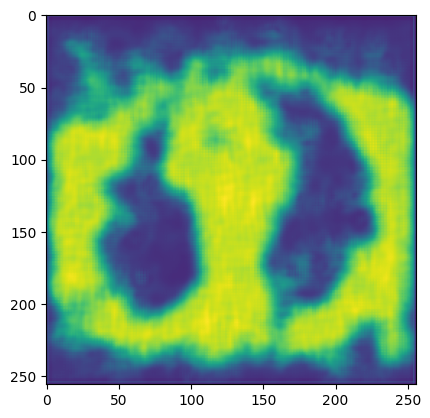

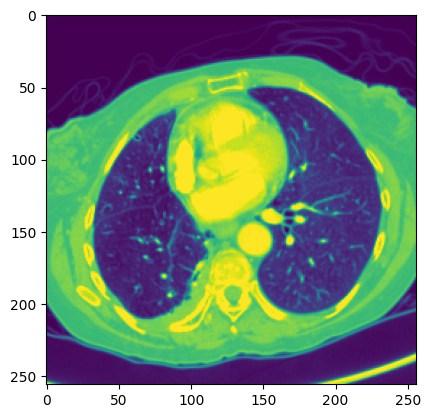

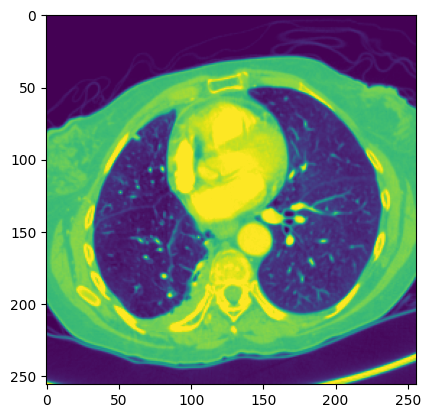

Validation loss: 111548.5078125:   0%|          | 0/15 [00:01<?, ?batch/s]


In [20]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
  with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free) in enumerate(tepoch):
      lesion = lesion.to(device)
      lesion_free = lesion_free.to(device)
      recon, mu, logvar = model(lesion)
      if batch_idx % 10 == 0:
        tepoch.set_description(f"Validation loss: {loss / len(lesion)}")
        recon = recon[0][0].cpu().numpy()
        # The next 3 lines is to make the small value smaller and big value bigger
        # big_scale = 1.01
        # small_scale = 0.99
        # recon = np.where(recon > recon.mean(), recon * big_scale, recon * small_scale)
        print(lesion_free[0][0].cpu().numpy().min(), lesion_free[0][0].cpu().numpy().max())
        print(lesion[0][0].cpu().numpy().min(), lesion[0][0].cpu().numpy().max())
        print(recon.min(), recon.max())
        plt.imshow(recon)
        plt.show()
        plt.imshow(lesion_free[0][0].cpu().numpy())
        plt.show()
        plt.imshow(lesion[0][0].cpu().numpy())
        plt.show()
        break

Validation loss: 111548.5078125:   0%|          | 0/15 [00:00<?, ?batch/s]

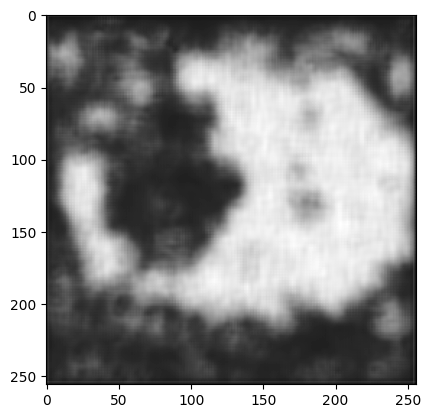

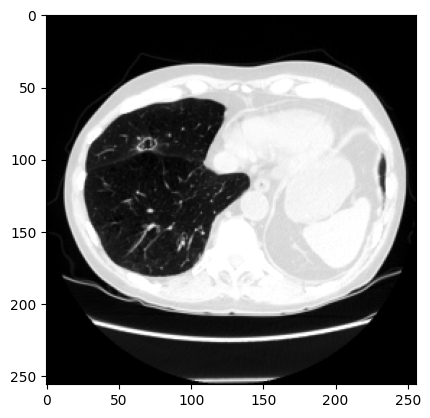

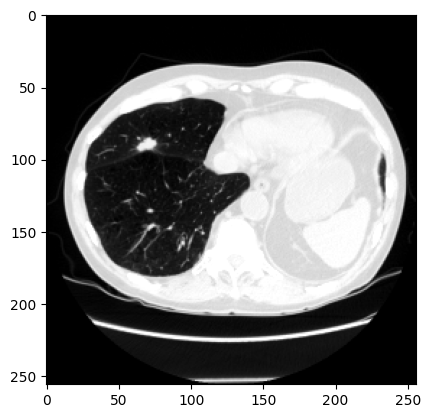

Validation loss: 111548.5078125:   0%|          | 0/15 [00:00<?, ?batch/s]


In [23]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
  with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free) in enumerate(tepoch):
      lesion = lesion.to(device)
      lesion_free = lesion_free.to(device)
      recon, mu, logvar = model(lesion)
      if batch_idx % 10 == 0:
        tepoch.set_description(f"Validation loss: {loss / len(lesion)}")
        plt.imshow(recon[0][0].cpu().numpy(), cmap='gray')
        plt.show()
        plt.imshow(lesion_free[0][0].cpu().numpy(), cmap='gray')
        plt.show()
        plt.imshow(lesion[0][0].cpu().numpy(), cmap='gray')
        plt.show()
        break

## Module 3: Prior UNet

First make the difference between input and the generated image.

In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        channels = [8, 16, 32, 64, 128]  # Number of feature maps
        
        # Encoder
        for i in range(4):
            encoder_block = nn.Sequential(
                nn.Conv2d(in_channels, channels[i], kernel_size=3),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(channels[i]),
                nn.Dropout2d(p=0.2),
                nn.Conv2d(channels[i], channels[i], kernel_size=3),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(channels[i]),
                nn.Dropout2d(p=0.2),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
            self.encoder_blocks.append(encoder_block)
            in_channels = channels[i]
        
        # Latent space
        self.latent_space = nn.Sequential(
            nn.Conv2d(channels[3], channels[4], kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(channels[4]),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(channels[4], channels[4], kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(channels[4]),
            nn.Dropout2d(p=0.2)
        )
        
        # Decoder
        for i in range(3, -1, -1):
            decoder_block = nn.Sequential(
                nn.Conv2d(channels[i+1], channels[i], kernel_size=3),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(channels[i]),
                nn.Dropout2d(p=0.2),
                nn.Conv2d(channels[i], channels[i], kernel_size=3),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(channels[i]),
                nn.Dropout2d(p=0.2),
                nn.ConvTranspose2d(channels[i], channels[i], kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(decoder_block)
        
        # Output layer
        self.out = nn.Conv2d(channels[0], out_channels, kernel_size=1)
    
    def forward(self, x):
        encoder_outputs = []
        
        # Encoder
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            encoder_outputs.append(x)
        
        x = self.latent_space(x)
        
        # Decoder
        for i, decoder_block in enumerate(self.decoder_blocks):
            x = decoder_block(x)
            x = torch.cat([x, encoder_outputs[-(i+1)]], dim=1)
        
        x = self.out(x)
        
        return x